In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import skimage as sk
import skimage.io as skio
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from skimage.color import rgb2gray
from skimage import data

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils
import math

import matplotlib.patches as patches
import random
import xml.etree.ElementTree as ET
import os
from tqdm import tqdm

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [ ]:
data_set_path = "/content/drive/MyDrive/Colab Notebooks/ibug_300W_large_face_landmark_dataset"

tree = ET.parse(data_set_path + '/labels_ibug_300W_train.xml')  
root = tree.getroot()
root_dir = '/content/drive/MyDrive/Colab Notebooks/ibug_300W_large_face_landmark_dataset'

In [4]:
face_boxes = [] 
img_filenames = []
landmark_set = []

for filename in root[2]:
  box = filename[0].attrib
  img_filenames.append(os.path.join(root_dir, filename.attrib['file']))

  box = filename[0].attrib
  # add corners with some extra padding
  new_w = int(float(box['width']) * 1.2)
  new_h = int(float(box['height'])* 1.2)
  diff_x = int((new_w - float(box['width']))/2)
  diff_y = int((new_h - float(box['height']))/2)

  face_boxes.append([float(box['left']) - diff_x, float(box['top']) - diff_y, new_w, new_h])

  # populate landmark_set
  landmarks = []
  for num in range(68):
    x_coords = int(filename[0][num].attrib['x'])
    y_coords = int(filename[0][num].attrib['y'])
    landmarks.append([x_coords, y_coords])
  landmark_set.append(landmarks)

landmark_set = np.array(landmark_set).astype('float32')   
face_boxes = np.array(face_boxes).astype('float32')

NameError: ignored

# Data Loading

In [5]:
from torch.utils.data import Dataset, DataLoader

def crop_img(im, box):
  # Make sure crop indices don't go out of bounds
  # for ind in box:
  
  if box[0] < 0:
    box[2] = box[2] + box[0]
    box[0] = 0
  if box[1] < 0:
    box[3] = box[3] + box[1]
    box[1] = 0
  if box[1] + box[3] > im.shape[0]:
    box[3] = im.shape[0] - box[1]
  if box[0] + box[2] > im.shape[1]:
    box[2] = im.shape[1] - box[0]
  box[3] = min(box[3], im.shape[0])
  box[2] = min(box[2], im.shape[1])
  # Crop
  im = im[box[1]:box[1]+box[3],box[0]:box[0]+box[2]]
  return im

def resize_img(im, resize_dim):
  im = resize(im, (resize_dim, resize_dim))
  return im

def crop_resize_landmarks(landmarks, box, resize_dim, imshape):
  xs = landmarks[:, 0] - box[0]
  ys = landmarks[:, 1] - box[1]

  # resize points
  scalar = resize_dim * 1.0 / imshape[0]
  xs = xs * scalar
  ys = ys * scalar
  return xs, ys

def show_im_w_pts(im, landmarks):
  plt.scatter(landmarks[:, 0], landmarks[:, 1], c='blue')
  plt.imshow(im, cmap='gray')

def save_im_w_pts(im, landmarks, fname, extra_landmarks=None):
  plt.scatter(landmarks[:, 0], landmarks[:, 1],c='red')
  if extra_landmarks is not None:
    plt.scatter(extra_landmarks[:, 0], extra_landmarks[:, 1],c='green')
  plt.imshow(im, cmap='gray')
  plt.savefig(fname)
  plt.close()

In [ ]:
# image_list = []
# for i in range(len(img_filenames)):
#   # image_list.append(sk.color.rgb2gray(skio.imread(img_filenames[i])))
#   image_list.append(skio.imread(img_filenames[i], as_gray=True))


In [ ]:
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage

class LandmarkDataset(Dataset):
  def __init__(self, start_index, end_index, images_name_set, landmarks_set, face_boxes, image_dimensions=244, augment=False):   
    self.image_dimensions = image_dimensions

    self.images_name_set = images_name_set[start_index: end_index]
    self.landmarks_set = landmarks_set[start_index: end_index]
    self.face_boxes = face_boxes[start_index: end_index]

    self.augment = augment

    if augment:
      self.jitter = transforms.ColorJitter(brightness = .5, contrast=.5, saturation=.5, hue=.2)

  def __getitem__(self, i):
    if torch.is_tensor(i):
            i = i.tolist()
    landmark = np.copy(self.landmarks_set[i])
    image = sk.color.rgb2gray(skio.imread(self.images_name_set[i]))
    box = self.face_boxes[i].astype(int)

    # Crop
    image = crop_img(image, box)

    # Resize
    landmark[:, 0], landmark[:, 1] = crop_resize_landmarks(landmark, box, self.image_dimensions, image.shape)
    image = resize_img(image, self.image_dimensions)

    sample = {'image': image.astype('float32'), 'landmarks': landmark.astype('float32')}
    if self.augment:
      sample = self.augment_transform(sample)

    return sample

  def __len__(self):
    return len(self.landmarks_set)

  def augment_transform(self, sample):
    # Source: https://imgaug.readthedocs.io/en/latest/source/examples_basics.html

    # Set random transfrom params and define transform function
    img, landmarks = sample['image'], sample['landmarks']

    # Multiply Blending
    to_multiply = random.random() + 0.5
    
    # Sometimes function to drop out (tear holes in)
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)

    seq = iaa.Sequential([
        iaa.Multiply(to_multiply),
        iaa.LinearContrast((0.75, 1.5)),
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05)),
        sometimes(iaa.Crop(percent=(0, 0.1))),
        # Scale/zoom, translate/move, rotate, shear      
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-25, 25),
            shear=(-8, 8)
        ),
        sometimes(iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5),
                    iaa.CoarseDropout(
                        (0.03, 0.15), size_percent=(0.02, 0.05),
                        per_channel=0.2
                    ),
                ])),
    ])
    # Set keypoints to transform
    keypoints = KeypointsOnImage([Keypoint(x=keypt[0],y=keypt[1]) for keypt in landmarks], shape = img.shape)
    im_aug, landmarks_aug = seq(image=img.astype(float), keypoints=keypoints)
    landmarks = np.array([[keypt.x, keypt.y] for keypt in landmarks_aug.keypoints])
    return {'image': im_aug, 'landmarks': landmarks}

In [ ]:
train_dataset = LandmarkDataset(0, 6000, img_filenames, landmark_set, face_boxes, augment=True) # imgs 0-5999
print("loaded training set")
print(len(train_dataset))
validation_dataset = LandmarkDataset(6000, 6665, img_filenames, landmark_set, face_boxes, augment=False) # imgs 6000-6665
print("loaded validation set")
print(len(validation_dataset))
# test_dataset = TestDataset()
# print("loaded test data set")

loaded training set
6000
loaded validation set
665


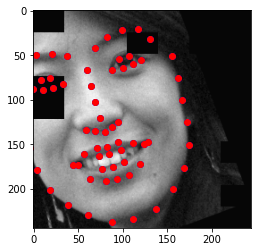

In [ ]:
sample = train_dataset.__getitem__(630)
im = sample['image']
keypts = sample['landmarks']
show_im_w_pts(im, keypts)
plt.scatter(keypts[:, 0], keypts[:, 1], c='red')
plt.imshow(im, cmap='gray')

# Training

In [ ]:
def train(dataloader, model, loss_function, optimizer):
    size = len(dataloader.dataset)
    model.train()
    
    total_loss = 0
    
    for i, batch in tqdm(enumerate(dataloader)):
        if (i % 100 == 0):
          print("processed another 100 batches")
        image, keypoint = batch['image'], batch['landmarks']
        # image = image.unsqueeze(0)
        image = image.float().unsqueeze(1)

        image, keypoint = image.to(device), keypoint.to(device)
        
        # Zero your gradients for every batch!
        model.zero_grad()
        # Make predictions for this batch
        output = model(image)
        output = output.flatten()
        keypoint = keypoint.flatten()
        loss = loss_function(output, keypoint)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        del image
        del keypoint
        torch.cuda.empty_cache()
        
    mean_loss = total_loss / (i + 1)
        
    return mean_loss

def validate(dataloader, model, loss_function, optimizer):
    size = len(dataloader.dataset)
    model.eval()
    
    total_loss = 0
    
    for i, batch in tqdm(enumerate(dataloader)):
        image, keypoint = batch['image'], batch['landmarks']
        # image = image.unsqueeze(0)
        image = image.float().unsqueeze(1)
        image, keypoint = image.to(device), keypoint.to(device)
        
        # Zero your gradients for every batch!
        model.zero_grad()
        # Make predictions for this batch
        output = model(image)
        output = output.flatten()
        keypoint = keypoint.flatten()

        loss = loss_function(output, keypoint)     
        total_loss += loss.item()

        del image
        del keypoint
        torch.cuda.empty_cache()
        
    mean_loss = total_loss / (i + 1)
        
    return mean_loss

def predict(dataloader, model):
    outputs = []
    model.eval()
    
    for batch in dataloader:
        image = batch['image']
        image = image.float().unsqueeze(1)
        image = image.to(device)
        
        output = model(image)

        output = output.cpu()
        outputs.append(output.detach().numpy())

        del image
    
    output_vector = np.stack(outputs, axis=0)
    return output_vector

In [13]:
BATCH_SIZE = 128
NUM_WORKERS = 2
NUM_EPOCHS = 15

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

NameError: ignored

In [ ]:
import torchvision.models as models
model = models.resnet18(pretrained=True)
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(2,2), bias=False)
model.fc = torch.nn.Linear(512 * model.layer1[0].expansion, 136)
# model = model.float()
model = model.to(device, dtype=torch.float)

# Loss function
loss_fn = torch.nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # learning rate=1e-3

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
torch.nn.Linear(512 * model.layer1[0].expansion, 136)

Linear(in_features=512, out_features=136, bias=True)

In [ ]:
train_losses = []
val_losses = []
import time

for epoch in range(NUM_EPOCHS):
    train_loss = train(train_loader, model, loss_fn, optimizer)
    print("Epoch Training Loss:", train_loss)
    torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/models/model'+time.strftime('%H%M%S')+'.pt')  
    val_loss = validate(val_loader, model, loss_fn, optimizer)
    print("Epoch Validation Loss:", val_loss)  
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print("finished epoch: ", epoch)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
1it [00:11, 11.52s/it]

processed another 100 batches


47it [04:39,  5.96s/it]


Epoch Training Loss: 16912.487200797874
Epoch Validation Loss: 16912.487200797874


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
6it [00:33,  5.67s/it]

finished epoch:  0



0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
1it [00:10, 10.95s/it]

processed another 100 batches


47it [04:38,  5.92s/it]


Epoch Training Loss: 9921.070624168882
Epoch Validation Loss: 9921.070624168882


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
6it [00:33,  5.57s/it]

finished epoch:  1



0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
1it [00:11, 11.39s/it]

processed another 100 batches


47it [04:39,  5.95s/it]


Epoch Training Loss: 5071.137736868351
Epoch Validation Loss: 5071.137736868351


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
6it [00:33,  5.63s/it]

finished epoch:  2



0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
1it [00:10, 10.89s/it]

processed another 100 batches


47it [04:38,  5.93s/it]


Epoch Training Loss: 2394.319876163564
Epoch Validation Loss: 2394.319876163564


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
6it [00:33,  5.59s/it]

finished epoch:  3



0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
1it [00:10, 10.88s/it]

processed another 100 batches


47it [04:39,  5.95s/it]


Epoch Training Loss: 1374.3398411527594
Epoch Validation Loss: 1374.3398411527594


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
6it [00:33,  5.61s/it]

finished epoch:  4



0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
1it [00:10, 10.88s/it]

processed another 100 batches


47it [04:40,  5.98s/it]


Epoch Training Loss: 1068.0849050968252
Epoch Validation Loss: 1068.0849050968252


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
6it [00:33,  5.65s/it]

finished epoch:  5



0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
1it [00:10, 11.00s/it]

processed another 100 batches


47it [04:42,  6.00s/it]


Epoch Training Loss: 931.0446556578291
Epoch Validation Loss: 931.0446556578291


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
6it [00:33,  5.65s/it]

finished epoch:  6



0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
1it [00:11, 11.09s/it]

processed another 100 batches


47it [04:39,  5.96s/it]


Epoch Training Loss: 788.5899242644614
Epoch Validation Loss: 788.5899242644614


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
6it [00:33,  5.65s/it]

finished epoch:  7



0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
1it [00:10, 10.91s/it]

processed another 100 batches


47it [04:39,  5.95s/it]


Epoch Training Loss: 657.2046443858045
Epoch Validation Loss: 657.2046443858045


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
6it [00:33,  5.62s/it]

finished epoch:  8



0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
1it [00:10, 10.74s/it]

processed another 100 batches


47it [04:41,  5.99s/it]


Epoch Training Loss: 563.9719777208694
Epoch Validation Loss: 563.9719777208694


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
6it [00:33,  5.56s/it]

finished epoch:  9



0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
1it [00:10, 10.98s/it]

processed another 100 batches


47it [04:39,  5.94s/it]


Epoch Training Loss: 507.57640108149104
Epoch Validation Loss: 507.57640108149104


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
6it [00:33,  5.57s/it]

finished epoch:  10



0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
1it [00:10, 10.99s/it]

processed another 100 batches


47it [04:39,  5.95s/it]


Epoch Training Loss: 457.0535674399518
Epoch Validation Loss: 457.0535674399518


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
6it [00:33,  5.57s/it]

finished epoch:  11



0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
1it [00:10, 10.80s/it]

processed another 100 batches


47it [04:37,  5.90s/it]


Epoch Training Loss: 382.17111335916724
Epoch Validation Loss: 382.17111335916724


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
6it [00:33,  5.59s/it]

finished epoch:  12



0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
1it [00:10, 10.89s/it]

processed another 100 batches


47it [04:39,  5.94s/it]


Epoch Training Loss: 278.1155155263049
Epoch Validation Loss: 278.1155155263049


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
6it [00:33,  5.60s/it]

finished epoch:  13



0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
1it [00:10, 10.94s/it]

processed another 100 batches


47it [04:40,  5.96s/it]


Epoch Training Loss: 223.55444822920128
Epoch Validation Loss: 223.55444822920128


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
6it [00:33,  5.64s/it]

finished epoch:  14



0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
1it [00:10, 10.86s/it]

processed another 100 batches


47it [04:40,  5.96s/it]


Epoch Training Loss: 203.30848206865028
Epoch Validation Loss: 203.30848206865028


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
6it [00:33,  5.64s/it]

finished epoch:  15



0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
1it [00:11, 11.13s/it]

processed another 100 batches


47it [04:39,  5.95s/it]


Epoch Training Loss: 187.73126285634143
Epoch Validation Loss: 187.73126285634143


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
6it [00:33,  5.55s/it]

finished epoch:  16



0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
1it [00:10, 10.78s/it]

processed another 100 batches


26it [02:44,  6.31s/it]


KeyboardInterrupt: ignored

In [ ]:
train_losses

[16912.487200797874,
 9921.070624168882,
 5071.137736868351,
 2394.319876163564,
 1374.3398411527594,
 1068.0849050968252,
 931.0446556578291,
 788.5899242644614,
 657.2046443858045,
 563.9719777208694,
 507.57640108149104,
 457.0535674399518,
 382.17111335916724,
 278.1155155263049,
 223.55444822920128,
 203.30848206865028,
 187.73126285634143]

In [ ]:
val_losses

[11610.314127604166,
 6512.843668619792,
 2726.730997721354,
 844.8290303548177,
 452.859135945638,
 279.5690409342448,
 257.27233632405597,
 357.0324350992839,
 219.48041534423828,
 202.8890177408854,
 205.31771341959634,
 175.07744598388672,
 145.66884104410806,
 133.22111129760742,
 197.55113220214844,
 138.6497014363607,
 158.5707753499349]

In [ ]:
train_losses = [16912.487200797874,
                9921.070624168882,
                5071.137736868351,
                2394.319876163564,
                1374.3398411527594,
                1068.0849050968252,
                931.0446556578291,
                788.5899242644614,
                657.2046443858045,
                563.9719777208694,
                507.57640108149104,
                457.0535674399518,
                382.17111335916724,
                278.1155155263049,
                223.55444822920128,
                203.30848206865028,
                187.73126285634143]

val_losses = [11610.314127604166,
              6512.843668619792,
              2726.730997721354,
              844.8290303548177,
              452.859135945638,
              279.5690409342448,
              257.27233632405597,
              357.0324350992839,
              219.48041534423828,
              202.8890177408854,
              205.31771341959634,
              175.07744598388672,
              145.66884104410806,
              133.22111129760742,
              197.55113220214844,
              138.6497014363607,
              158.5707753499349]

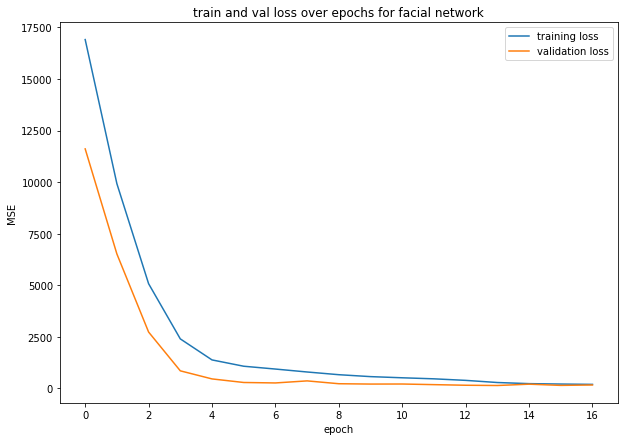

In [ ]:
plt.figure(figsize = (10, 7))
plt.plot(range(len(train_losses)), train_losses, label = 'training loss')
plt.plot(range(len(val_losses)), val_losses, label = 'validation loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.title('train and val loss over epochs for facial network')
plt.legend()
plt.savefig("more_points_train_val_loss.jpg")

Predict

[[ 34.246372  51.65595 ]
 [ 30.912537  76.820915]
 [ 29.58094  101.81712 ]
 [ 30.623823 127.292015]
 [ 36.040348 151.6751  ]
 [ 47.141212 173.25117 ]
 [ 61.325993 191.48842 ]
 [ 78.56014  206.34879 ]
 [100.147644 212.25734 ]
 [123.32499  211.4193  ]
 [144.46138  200.8582  ]
 [164.3533   187.49979 ]
 [180.7136   171.49654 ]
 [192.93916  151.31795 ]
 [200.63019  129.9506  ]
 [205.91019  106.66361 ]
 [209.69272   83.07661 ]
 [ 54.26073   36.990532]
 [ 67.57101   28.652212]
 [ 83.29318   28.733318]
 [ 99.42731   34.11254 ]
 [112.99961   43.079445]
 [141.12868   47.053043]
 [157.00252   43.52335 ]
 [172.63635   44.228897]
 [187.00217   50.2459  ]
 [196.3263    62.30122 ]
 [124.49741   63.928146]
 [122.17503   79.81977 ]
 [119.9138    95.217186]
 [117.506905 111.347015]
 [ 96.78183  118.935295]
 [105.06302  123.61064 ]
 [114.08629  127.8605  ]
 [124.121704 126.496765]
 [132.9853   124.88023 ]
 [ 69.301445  56.31139 ]
 [ 80.30564   52.223183]
 [ 91.86316   54.558743]
 [100.4216    64.487625]


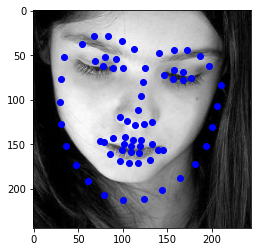

In [ ]:
im = validation_dataset[70]["image"]
keypts = y_predict[70].reshape((68, 2))
show_im_w_pts(im, keypts)
print(keypts)
print(len(keypts[0]))

In [9]:
data_set_path = "/content/drive/MyDrive/Colab Notebooks/ibug_300W_large_face_landmark_dataset"
tree = ET.parse(data_set_path +'/labels_ibug_300W_test_parsed.xml')
root = tree.getroot()
root_dir = '/content/drive/MyDrive/Colab Notebooks/ibug_300W_large_face_landmark_dataset'

# data_set_path = "/content/drive/MyDrive/Colab Notebooks/ibug_300W_large_face_landmark_dataset"

# tree = ET.parse(data_set_path + '/labels_ibug_300W_train.xml')  
# root = tree.getroot()
# root_dir = '/content/drive/MyDrive/Colab Notebooks/ibug_300W_large_face_landmark_dataset'

face_boxes_test = [] 
img_filenames_test = [] 

for filename in root[2]:
  img_filenames_test.append(os.path.join(root_dir, filename.attrib['file']))
  box = filename[0].attrib
  new_w = int(float(box['width']) * 1.2)
  new_h = int(float(box['height'])* 1.2)
  diff_x = int((new_w - float(box['width']))/2)
  diff_y = int((new_h - float(box['height']))/2)
  face_boxes_test.append([float(box['left'])-diff_x, float(box['top'])-diff_y, new_w, new_h]) 
face_boxes_test = np.array(face_boxes_test).astype('float32')

In [10]:
class TestDataset(Dataset):
  def __init__(self, images_name_set, face_boxes, image_dimensions=244):   
    self.image_dimensions = image_dimensions

    self.images_name_set = images_name_set
    self.face_boxes = face_boxes

  def __getitem__(self, i):
    if torch.is_tensor(i):
            i = i.tolist()

    image = sk.color.rgb2gray(skio.imread(self.images_name_set[i]))
    box = self.face_boxes[i].astype(int)

    # Crop
    image = crop_img(image, box)

    # Resize
    image = resize_img(image, self.image_dimensions)

    return image

  def __len__(self):
    return len(self.images_name_set)

In [ ]:
def predict(dataloader, model):
    outputs = []
    model.eval()
    
    for batch in dataloader:
        image = batch
        image = image.float().unsqueeze(1)
        image = image.to(device)
        
        output = model(image)

        output = output.cpu()
        outputs.append(output.detach().numpy().reshape((68, 2)))

        del image
    
    output_vector = np.stack(outputs, axis=0)
    return output_vector

In [14]:
NUM_WORKERS = 2
test_dataset = TestDataset(img_filenames_test, face_boxes_test)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=NUM_WORKERS)

In [ ]:
test_predict = predict(test_loader, model)
torch.save(test_predict, 'test_predict.pt')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  if sys.path[0] == '':


In [8]:
test_predict = torch.load("/content/test_predict.pt")

(68, 2)

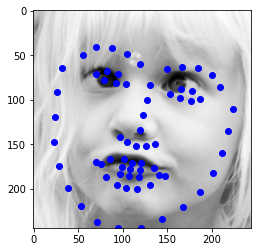

In [15]:
im = test_dataset[70]
keypts = test_predict[70]
show_im_w_pts(im, keypts)
plt.savefig("TestPrediction1.jpg")
keypts.shape

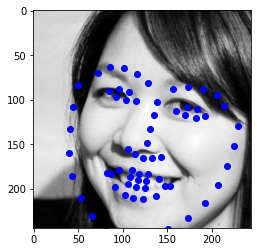

In [16]:
im = test_dataset[69]
keypts = test_predict[69]
show_im_w_pts(im, keypts)
plt.savefig("TestPrediction2.jpg")

In [63]:
def get_original_image_w_pts(keypoint_set, dataset, dataset_ind, im_filenames_lst, boxes_lst):
  im_ind = dataset_ind
  im = sk.color.rgb2gray(skio.imread(im_filenames_lst[im_ind]))
  box = boxes_lst[im_ind].astype(int)
  keypoints = np.copy(keypoint_set[dataset_ind])
  ret_pts = np.copy(keypoint_set[dataset_ind])
  # / dataset.image_dimensions
  ret_pts[:,0] = (keypoints[:,0] / dataset.image_dimensions)*box[2] + box[0]
  ret_pts[:,1] = (keypoints[:,1] / dataset.image_dimensions)*box[3] + box[1]
  return im, ret_pts

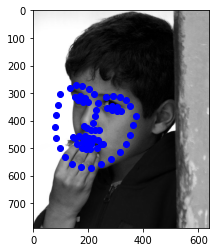

In [71]:
a, b = get_original_image_w_pts(test_predict, test_dataset, 0, img_filenames_test, face_boxes_test)
show_im_w_pts(a, b)
plt.savefig("TestPrediction3.jpg")

# Saving to CSV

In [69]:
def get_original_pts(keypoint_set, dataset, dataset_ind, im_filenames_lst, boxes_lst):
  box = boxes_lst[dataset_ind].astype(int)
  keypoints = np.copy(keypoint_set[dataset_ind])
  ret_pts = np.copy(keypoint_set[dataset_ind])
  # / dataset.image_dimensions
  ret_pts[:,0] = (keypoints[:,0] / dataset.image_dimensions)*box[2] + box[0]
  ret_pts[:,1] = (keypoints[:,1] / dataset.image_dimensions)*box[3] + box[1]
  return ret_pts

In [70]:
def to_csv(keypoints_lst, fname="/content/predictions.csv"):
  ids = np.arange(len(keypoints_lst))
  csv_array = np.zeros((len(keypoints_lst), 2))
  csv_array[:,0] = ids.astype(int)
  csv_array[:,1] = keypoints_lst
  np.savetxt(fname, csv_array, delimiter=',')

test_keypt_predictions_formatted = []

for i, keypoints in enumerate(test_predict):
  keypoints = get_original_pts(test_predict, test_dataset, i, img_filenames_test, face_boxes_test)

  for point in keypoints:
    test_keypt_predictions_formatted.append(point[0])
    test_keypt_predictions_formatted.append(point[1])

print(len(test_keypt_predictions_formatted))
to_csv(test_keypt_predictions_formatted)

import csv
with open('/content/predictions.csv',newline='') as f:
    r = csv.reader(f)
    data = [line for line in r]

137088


# Try my own photos